# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

from torchvision import datasets, transforms
import torchvision

import sys, os
import matplotlib.pyplot as plt

import numpy as np
import random


import model

from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import OneCycleLR

from modular.create_data_loader import create_train_data_loader, create_test_data_loader
from modular.dataloader import Cifar10SearchDataset
from modular.transforms import CustomResnetTransforms
from modular.train import model_training, model_testing
from modular.plots import plot_losses,plot_images 

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
### this is for running in local ###
try:
    os.environ['HTTP_PROXY']='http://185.46.212.90:80'
    os.environ['HTTPS_PROXY']='http://185.46.212.90:80'
    print ("proxy_exported")
except:
    None

proxy_exported


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    
device = torch.device("cuda" if cuda else "cpu")
print(device)

CUDA Available? True
cuda


# Transformation of Data

In [4]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = CustomResnetTransforms.train_transforms(means, stds)
test_transforms = CustomResnetTransforms.test_transforms(means, stds)

# Dataset and Creating Train/Test Split

In [5]:
train = Cifar10SearchDataset('./data', train=True, download=True, transform=train_transforms)
test = Cifar10SearchDataset('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


# Dataloader Arguments & Test/Train Dataloaders


In [6]:
# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=1024, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

print (len(train_loader),len(test_loader))

49 10


# Model Params for Custom Resnet
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [7]:
m = model.Net_assign9().to(device)
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
           Dropout-4           [-1, 32, 32, 32]               0
            Conv2d-5           [-1, 32, 32, 32]             320
            Conv2d-6          [-1, 128, 32, 32]           4,224
              ReLU-7          [-1, 128, 32, 32]               0
       BatchNorm2d-8          [-1, 128, 32, 32]             256
           Dropout-9          [-1, 128, 32, 32]               0
           Conv2d-10           [-1, 64, 16, 16]          73,792
           Conv2d-11           [-1, 64, 16, 16]             640
           Conv2d-12          [-1, 128, 16, 16]           8,320
             ReLU-13          [-1, 128, 16, 16]               0
      BatchNorm2d-14          [-1, 128,

## Calculating the max and min LR using one cycle LR policy

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.83E-03


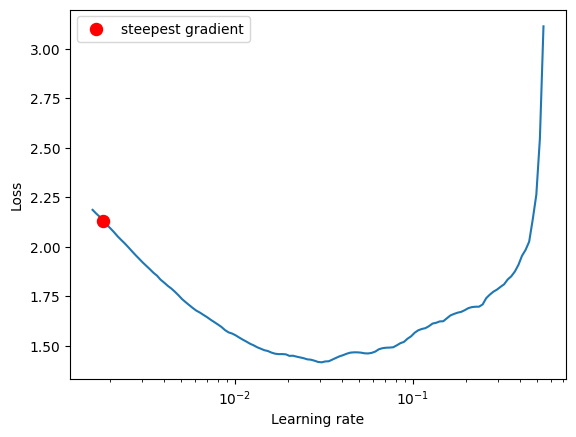

SystemExit: 

In [8]:
m = model.Net_assign9().to(device)
optimizer = optim.Adam(m.parameters(), lr=0.001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(m, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state
sys.exit()

# Let's Train and test our model
### using one cycle lr policy

In [9]:
EPOCHS = 30

scheduler = OneCycleLR(
        optimizer,
        max_lr=1.83E-03,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start= 5.0/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear',
    )


In [10]:
for epoch in range(EPOCHS):
    printmd("**EPOCH: "+ str(epoch)+"**"),
    train_acc,train_losses = model_training(m, device, train_loader, optimizer, epoch, scheduler, criterion)
    test_acc,test_losses,miss_classified_data = model_testing(m, device, test_loader, criterion)

**EPOCH: 0**

Loss=1.844719648361206 LR =0.00038212500000000003 Batch_id=48 Accuracy=23.99: 100% 49/49 [00:06<00:00,  7.70it/s] 



Test set: Average loss: 0.0018, Accuracy: 3268/10000 (32.68%)



**EPOCH: 1**

Loss=1.443009853363037 LR =0.00074595 Batch_id=48 Accuracy=41.94: 100% 49/49 [00:06<00:00,  7.84it/s]             



Test set: Average loss: 0.0014, Accuracy: 4926/10000 (49.26%)



**EPOCH: 2**

Loss=1.200546145439148 LR =0.001109775 Batch_id=48 Accuracy=52.94: 100% 49/49 [00:06<00:00,  7.93it/s]           



Test set: Average loss: 0.0012, Accuracy: 5691/10000 (56.91%)



**EPOCH: 3**

Loss=1.069000482559204 LR =0.0014736 Batch_id=48 Accuracy=59.86: 100% 49/49 [00:06<00:00,  7.98it/s]             



Test set: Average loss: 0.0011, Accuracy: 6220/10000 (62.20%)



**EPOCH: 4**

Loss=0.9530892968177795 LR =0.0018285062718367347 Batch_id=48 Accuracy=64.85: 100% 49/49 [00:06<00:00,  8.02it/s]



Test set: Average loss: 0.0010, Accuracy: 6671/10000 (66.71%)



**EPOCH: 5**

Loss=0.8352789282798767 LR =0.0017553135918367347 Batch_id=48 Accuracy=68.48: 100% 49/49 [00:05<00:00,  8.18it/s]



Test set: Average loss: 0.0008, Accuracy: 7114/10000 (71.14%)



**EPOCH: 6**

Loss=0.757100522518158 LR =0.0016821209118367346 Batch_id=48 Accuracy=71.98: 100% 49/49 [00:06<00:00,  8.11it/s] 



Test set: Average loss: 0.0008, Accuracy: 7389/10000 (73.89%)



**EPOCH: 7**

Loss=0.6210644841194153 LR =0.0016089282318367346 Batch_id=48 Accuracy=74.54: 100% 49/49 [00:05<00:00,  8.18it/s]



Test set: Average loss: 0.0007, Accuracy: 7482/10000 (74.82%)



**EPOCH: 8**

Loss=0.6164026260375977 LR =0.0015357355518367346 Batch_id=48 Accuracy=76.28: 100% 49/49 [00:06<00:00,  7.91it/s]



Test set: Average loss: 0.0007, Accuracy: 7717/10000 (77.17%)



**EPOCH: 9**

Loss=0.6661574244499207 LR =0.0014625428718367346 Batch_id=48 Accuracy=77.69: 100% 49/49 [00:06<00:00,  8.10it/s]



Test set: Average loss: 0.0006, Accuracy: 7873/10000 (78.73%)



**EPOCH: 10**

Loss=0.6125473976135254 LR =0.0013893501918367348 Batch_id=48 Accuracy=78.99: 100% 49/49 [00:06<00:00,  8.01it/s]



Test set: Average loss: 0.0006, Accuracy: 7868/10000 (78.68%)



**EPOCH: 11**

Loss=0.5411957502365112 LR =0.0013161575118367348 Batch_id=48 Accuracy=80.32: 100% 49/49 [00:06<00:00,  8.03it/s]



Test set: Average loss: 0.0006, Accuracy: 8000/10000 (80.00%)



**EPOCH: 12**

Loss=0.5203799605369568 LR =0.0012429648318367345 Batch_id=48 Accuracy=81.14: 100% 49/49 [00:06<00:00,  8.02it/s]



Test set: Average loss: 0.0006, Accuracy: 7999/10000 (79.99%)



**EPOCH: 13**

Loss=0.5041325688362122 LR =0.0011697721518367347 Batch_id=48 Accuracy=81.94: 100% 49/49 [00:06<00:00,  8.08it/s] 



Test set: Average loss: 0.0006, Accuracy: 8094/10000 (80.94%)



**EPOCH: 14**

Loss=0.5120311379432678 LR =0.0010965794718367347 Batch_id=48 Accuracy=82.53: 100% 49/49 [00:06<00:00,  8.00it/s] 



Test set: Average loss: 0.0006, Accuracy: 8137/10000 (81.37%)



**EPOCH: 15**

Loss=0.49836573004722595 LR =0.0010233867918367347 Batch_id=48 Accuracy=83.38: 100% 49/49 [00:06<00:00,  8.12it/s]



Test set: Average loss: 0.0005, Accuracy: 8153/10000 (81.53%)



**EPOCH: 16**

Loss=0.4388186037540436 LR =0.0009501941118367347 Batch_id=48 Accuracy=83.92: 100% 49/49 [00:06<00:00,  7.94it/s] 



Test set: Average loss: 0.0005, Accuracy: 8166/10000 (81.66%)



**EPOCH: 17**

Loss=0.4837905466556549 LR =0.0008770014318367346 Batch_id=48 Accuracy=84.90: 100% 49/49 [00:06<00:00,  7.97it/s] 



Test set: Average loss: 0.0006, Accuracy: 8137/10000 (81.37%)



**EPOCH: 18**

Loss=0.42774420976638794 LR =0.0008038087518367348 Batch_id=48 Accuracy=85.06: 100% 49/49 [00:06<00:00,  7.72it/s]



Test set: Average loss: 0.0005, Accuracy: 8233/10000 (82.33%)



**EPOCH: 19**

Loss=0.42089977860450745 LR =0.0007306160718367346 Batch_id=48 Accuracy=86.00: 100% 49/49 [00:06<00:00,  8.04it/s]



Test set: Average loss: 0.0005, Accuracy: 8311/10000 (83.11%)



**EPOCH: 20**

Loss=0.3820376396179199 LR =0.0006574233918367346 Batch_id=48 Accuracy=86.52: 100% 49/49 [00:06<00:00,  8.02it/s] 



Test set: Average loss: 0.0005, Accuracy: 8333/10000 (83.33%)



**EPOCH: 21**

Loss=0.3753972053527832 LR =0.0005842307118367348 Batch_id=48 Accuracy=87.07: 100% 49/49 [00:06<00:00,  7.84it/s] 



Test set: Average loss: 0.0005, Accuracy: 8317/10000 (83.17%)



**EPOCH: 22**

Loss=0.3461574912071228 LR =0.0005110380318367348 Batch_id=48 Accuracy=87.74: 100% 49/49 [00:06<00:00,  7.86it/s] 



Test set: Average loss: 0.0005, Accuracy: 8390/10000 (83.90%)



**EPOCH: 23**

Loss=0.35083261132240295 LR =0.00043784535183673473 Batch_id=48 Accuracy=87.86: 100% 49/49 [00:06<00:00,  7.86it/s]



Test set: Average loss: 0.0005, Accuracy: 8396/10000 (83.96%)



**EPOCH: 24**

Loss=0.3548028767108917 LR =0.0003646526718367345 Batch_id=48 Accuracy=88.73: 100% 49/49 [00:06<00:00,  8.00it/s]  



Test set: Average loss: 0.0005, Accuracy: 8446/10000 (84.46%)



**EPOCH: 25**

Loss=0.35930389165878296 LR =0.0002914599918367347 Batch_id=48 Accuracy=89.30: 100% 49/49 [00:06<00:00,  7.89it/s] 



Test set: Average loss: 0.0005, Accuracy: 8441/10000 (84.41%)



**EPOCH: 26**

Loss=0.3009299635887146 LR =0.00021826731183673467 Batch_id=48 Accuracy=89.67: 100% 49/49 [00:06<00:00,  8.10it/s] 



Test set: Average loss: 0.0005, Accuracy: 8468/10000 (84.68%)



**EPOCH: 27**

Loss=0.29890307784080505 LR =0.00014507463183673465 Batch_id=48 Accuracy=90.09: 100% 49/49 [00:06<00:00,  7.89it/s]



Test set: Average loss: 0.0005, Accuracy: 8476/10000 (84.76%)



**EPOCH: 28**

Loss=0.31361302733421326 LR =7.188195183673463e-05 Batch_id=48 Accuracy=90.36: 100% 49/49 [00:06<00:00,  7.99it/s] 



Test set: Average loss: 0.0005, Accuracy: 8519/10000 (85.19%)



**EPOCH: 29**

Loss=0.2896941900253296 LR =-1.310728163265388e-06 Batch_id=48 Accuracy=90.70: 100% 49/49 [00:06<00:00,  8.05it/s] 



Test set: Average loss: 0.0005, Accuracy: 8508/10000 (85.08%)



## Displaying Train Test Accuracy and Loss Plots

mkdir: cannot create directory ‘images’: File exists


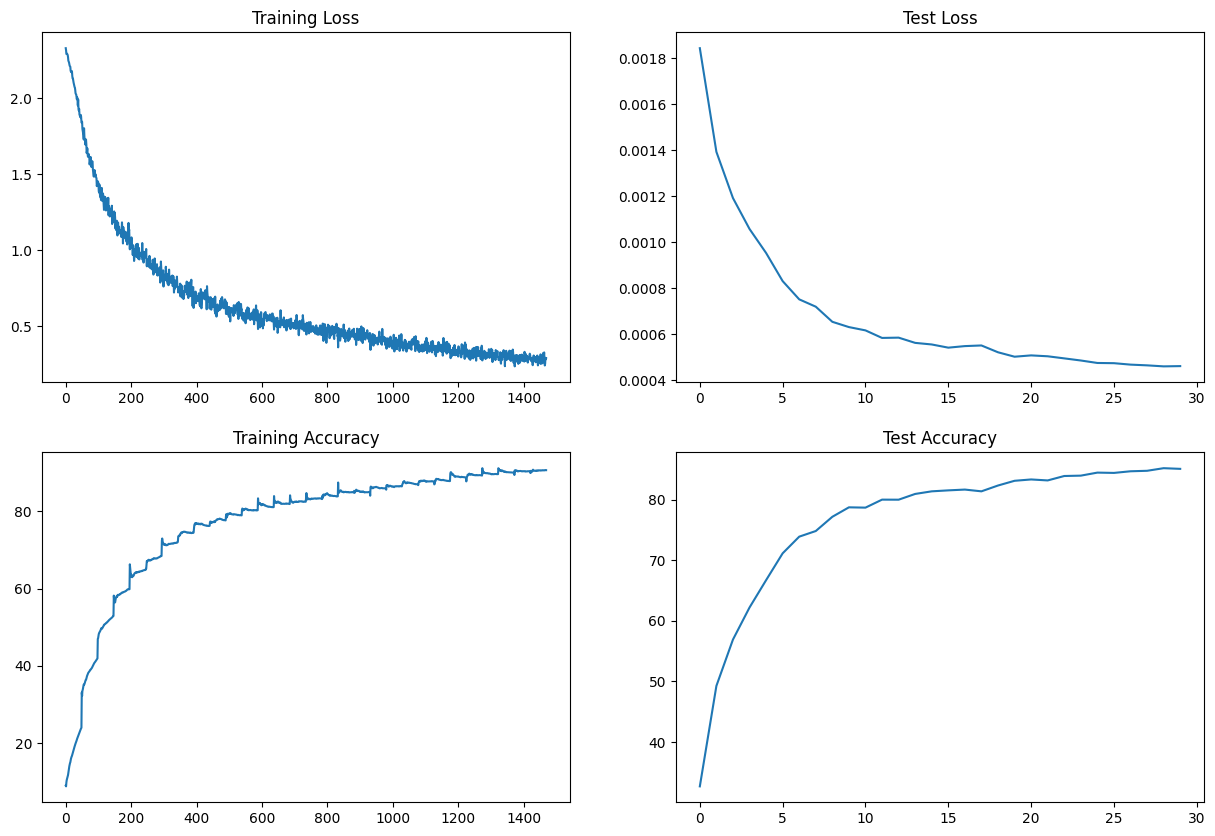

In [11]:
os.system('mkdir images')
fig = plot_losses(train_losses, train_acc, test_losses, test_acc)
fig.savefig('images/Accuracy & Loss.jpg')

## Displaying Sample Miss Classified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

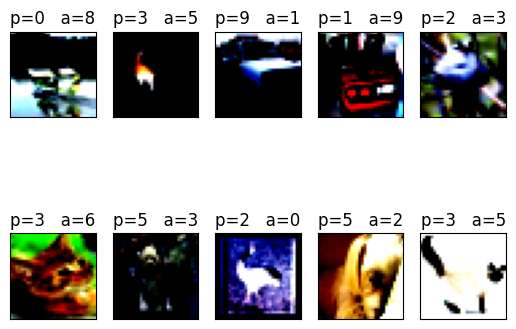

In [12]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

random_images = range(0,len(miss_classified_data[0]))
random_selects = random.sample(random_images, 10)

fig_miss_class = plt.figure()
count=0
for i in random_selects:
    plt.subplot(2,5,count+1)
    plt.imshow(miss_classified_data[2][i].cpu().permute(1,2,0))   
    plt.title("p="+str(miss_classified_data[1][i])+"   "+"a="+str(miss_classified_data[0][i]))
    plt.xticks([])
    plt.yticks([])
    count+=1

fig_miss_class.savefig("images/mis_classified_image.jpg")

## Displaying Sample Train Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

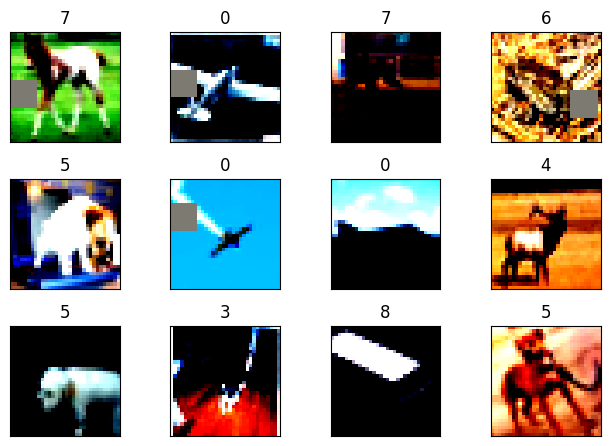

In [13]:
batch_data_train, batch_label_train = next(iter(train_loader))
figure_train = plot_images(batch_data_train, batch_label_train.tolist(), 12, 3, 'CIFAR10')
figure_train.savefig("images/train_dataset.jpg")

## Displaying Sample Test Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

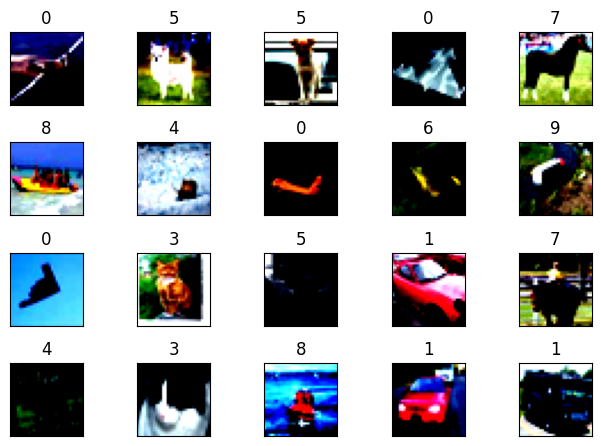

In [14]:
batch_data_test, batch_label_test = next(iter(test_loader))
figure_test = plot_images(batch_data_test, batch_label_test.tolist(), 20, 4, 'CIFAR10')
figure_test.savefig("images/test_dataset.jpg")

**********************************************************